In [3]:
import numpy as np
import scipy as sp
import scipy.optimize

import matplotlib.pyplot as plt

strQx = "CH_qx.txt"
strQy = "CH_qy.txt"
strNx = "CH_bestand.txt"

def ReadDate(strqx,strqy,strbest):
    qxdict = dict() # qx(gender, time, age) returns (qx, nx, dx) # gender 0 man 1 woman
    QxRawData = np.loadtxt(strqx, skiprows=1)
    QyRawData = np.loadtxt(strqy, skiprows=1)
    BestRawData = np.loadtxt(strbest, skiprows=1)
    
    print("Processing Bestand")
    for i in range(len(BestRawData)):
        qxdict[(0,BestRawData[i,0],BestRawData[i,1])] = [None, BestRawData[i,2], None]
        qxdict[(1,BestRawData[i,0],BestRawData[i,1])] = [None, BestRawData[i,3], None]
    
    print("Processing Qx")
    for i in range(len(QxRawData)):
        t = QxRawData[i,0]
        x = QxRawData[i,1]
        qx = QxRawData[i,3]
        Nx = qxdict[(0,t,x)][1] 
        Dx = qx * Nx
        qxdict[(0,t,x)] = [qx, Nx, Dx]
 
    print("Processing Qy")
    for i in range(len(QyRawData)):
        t = QyRawData[i,0]
        x = QyRawData[i,1]
        qx = QyRawData[i,3]
        Nx = qxdict[(1,t,x)][1] 
        Dx = qx * Nx
        qxdict[(1,t,x)] = [qx, Nx, Dx]
    
    return qxdict

QxData = ReadDate(strQx,strQy,strNx)

Processing Bestand
Processing Qx
Processing Qy


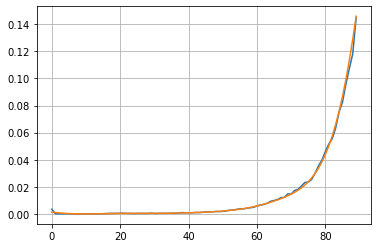

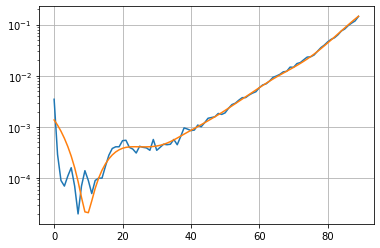

In [9]:
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import splu


def speyediff(N, d, format='csc'):
    """
    (utility function)
    Construct a d-th order sparse difference matrix based on 
    an initial N x N identity matrix
    
    Final matrix (N-d) x N
    """
    
    assert not (d < 0), "d must be non negative"
    shape     = (N-d, N)
    diagonals = np.zeros(2*d + 1)
    diagonals[d] = 1.
    for i in range(d):
        diff = diagonals[:-1] - diagonals[1:]
        diagonals = diff
    offsets = np.arange(d+1)
    spmat = sparse.diags(diagonals, offsets, shape, format=format)
    return spmat


def whittaker_smooth(y, lmbd, d = 2):
    """
    Implementation of the Whittaker smoothing algorithm,
    based on the work by Eilers [1].
    [1] P. H. C. Eilers, "A perfect smoother", Anal. Chem. 2003, (75), 3631-3636
    
    The larger 'lmbd', the smoother the data.
    For smoothing of a complete data series, sampled at equal intervals
    This implementation uses sparse matrices enabling high-speed processing
    of large input vectors
    
    ---------
    
    Arguments :
    
    y       : vector containing raw data
    lmbd    : parameter for the smoothing algorithm (roughness penalty)
    d       : order of the smoothing 
    
    ---------
    Returns :
    
    z       : vector of the smoothed data.
    """

    m = len(y)
    E = sparse.eye(m, format='csc')
    D = speyediff(m, d, format='csc')
    coefmat = E + lmbd * D.conj().T.dot(D)
    z = splu(coefmat).solve(y)
    return z   

y = np.zeros(110)
t=2018
gender = 0

for i in range(110):
    y[i]=QxData[(gender,t,i)][0]
    
lam = 100

y2 = whittaker_smooth(y, lam)

plt.figure(1)
x=range(90)
plt.plot(x,y[x],x,y2[x])
plt.grid(True)

plt.figure(2)
x=range(90)
plt.semilogy(x,y[x],x,y2[x])
plt.grid(True)

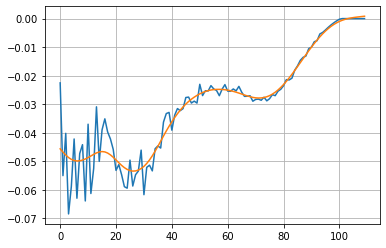

In [11]:
from scipy import stats
T=range(2019-30,2019)
lamdaraw = np.zeros(110)
for i in range(110):
    myt = []
    qxlog = []
    for t in T:
        myt.append(t)
        qxlog.append(np.log(max(0.000001,QxData[(gender,t,i)][0])))
    slope, intercept, r_value, p_value, std_err = stats.linregress(myt,qxlog)
    lamdaraw[i] = min(slope,0)

lam = 250
    
mylambda = whittaker_smooth(lamdaraw, lam)
    
plt.figure(3)
plt.plot(range(110),lamdaraw,range(110),mylambda)
plt.grid(True)
    